A multi-label classifier model that use combination of tags, simultaneously identifying its sentiment (positive/negative) and all the topics it covers, such as Graphics, Gameplay, Story, Sound, Performance, and Bugs.

**1. Import libraries**

In [ ]:
# Install all required packages for the project
!pip install transformers[torch] datasets scikit-learn pandas kagglehub matplotlib seaborn plotly -q

# --- Core Libraries ---
import os
import kagglehub
import pandas as pd
import numpy as np
import torch

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.gridspec import GridSpec

# --- Hugging Face Deep Learning Libraries ---
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# --- Metrics for Evaluation ---
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from IPython.display import display, HTML

# Set a consistent style for our plots
sns.set_style('whitegrid')

# Gradio for output interface demo
import gradio as gr
from collections import Counter

#Transformer model
MODEL_NAME = "distilroberta-base"

print("All libraries have been installed and imported successfully.")

All libraries have been installed and imported successfully.


**2. Data Collection**

In [ ]:
# --- Data Collection ---
print("--- Data Collection ---")
print("Downloading dataset from Kaggle...")

try:
    path = kagglehub.dataset_download("andrewmvd/steam-reviews")
    csv_file_path = os.path.join(path, "dataset.csv")

    # --- Step 1: Initial Load to Inspect Columns with 5 rows ---
    print("\nLoading a small sample of the data to inspect all available columns...")
    df_sample = pd.read_csv(csv_file_path, nrows=5)
    print("Available columns in the dataset:")
    print(df_sample.columns.tolist())
   # --- Step 2: Full Load with Selected Columns ---
    # We define which ones we actually want to use.
    columns_to_use = ['review_text', 'review_score', 'review_votes']

    print(f"\nColumns selected for this project: {columns_to_use}")
    print("Now loading the full subset of data (50,000 rows) with only these columns...")

    # Load the main DataFrame 'df' with only the columns we need
    df = pd.read_csv(
        csv_file_path,
        usecols=columns_to_use,
        nrows=50000
    )

    print(f"\nDataFrame 'df' loaded successfully with {len(df)} rows.")

    # Display the head of the final DataFrame to confirm
    print("\nDisplaying the first few rows of the final loaded data:")
    display(df.head())

except Exception as e:
    print(f"An error occurred during download or loading: {e}")
    df = pd.DataFrame() # Create an empty DataFrame if it fails

--- Data Collection ---

Loading a small sample of the data to inspect all available columns...
Available columns in the dataset:
['app_id', 'app_name', 'review_text', 'review_score', 'review_votes']

Columns selected for this project: ['review_text', 'review_score', 'review_votes']
Now loading the full subset of data (50,000 rows) with only these columns...

DataFrame 'df' loaded successfully with 50000 rows.

Displaying the first few rows of the final loaded data:


,review_text,review_score,review_votes
0,Ruined my life.,1,0
1,This will be more of a ''my experience with th...,1,1
2,This game saved my virginity.,1,0
3,• Do you like original games? • Do you like ga...,1,0
4,"Easy to learn, hard to master.",1,1


**3. Data Cleaning and Feature Engineering**

In [ ]:
# --- Data Cleaning & Feature Engineering ---
df.dropna(subset=['review_text'], inplace=True)
df['review_text'] = df['review_text'].astype(str)
df['sentiment'] = df['review_score'].map({1: 'Positive', -1: 'Negative'})

**4. Exploratory Data Analysis (EDA)**


--- Generating Unfiltered Word Clouds ---
Generating Word Cloud for Positive Reviews...
Generating Word Cloud for Negative Reviews...


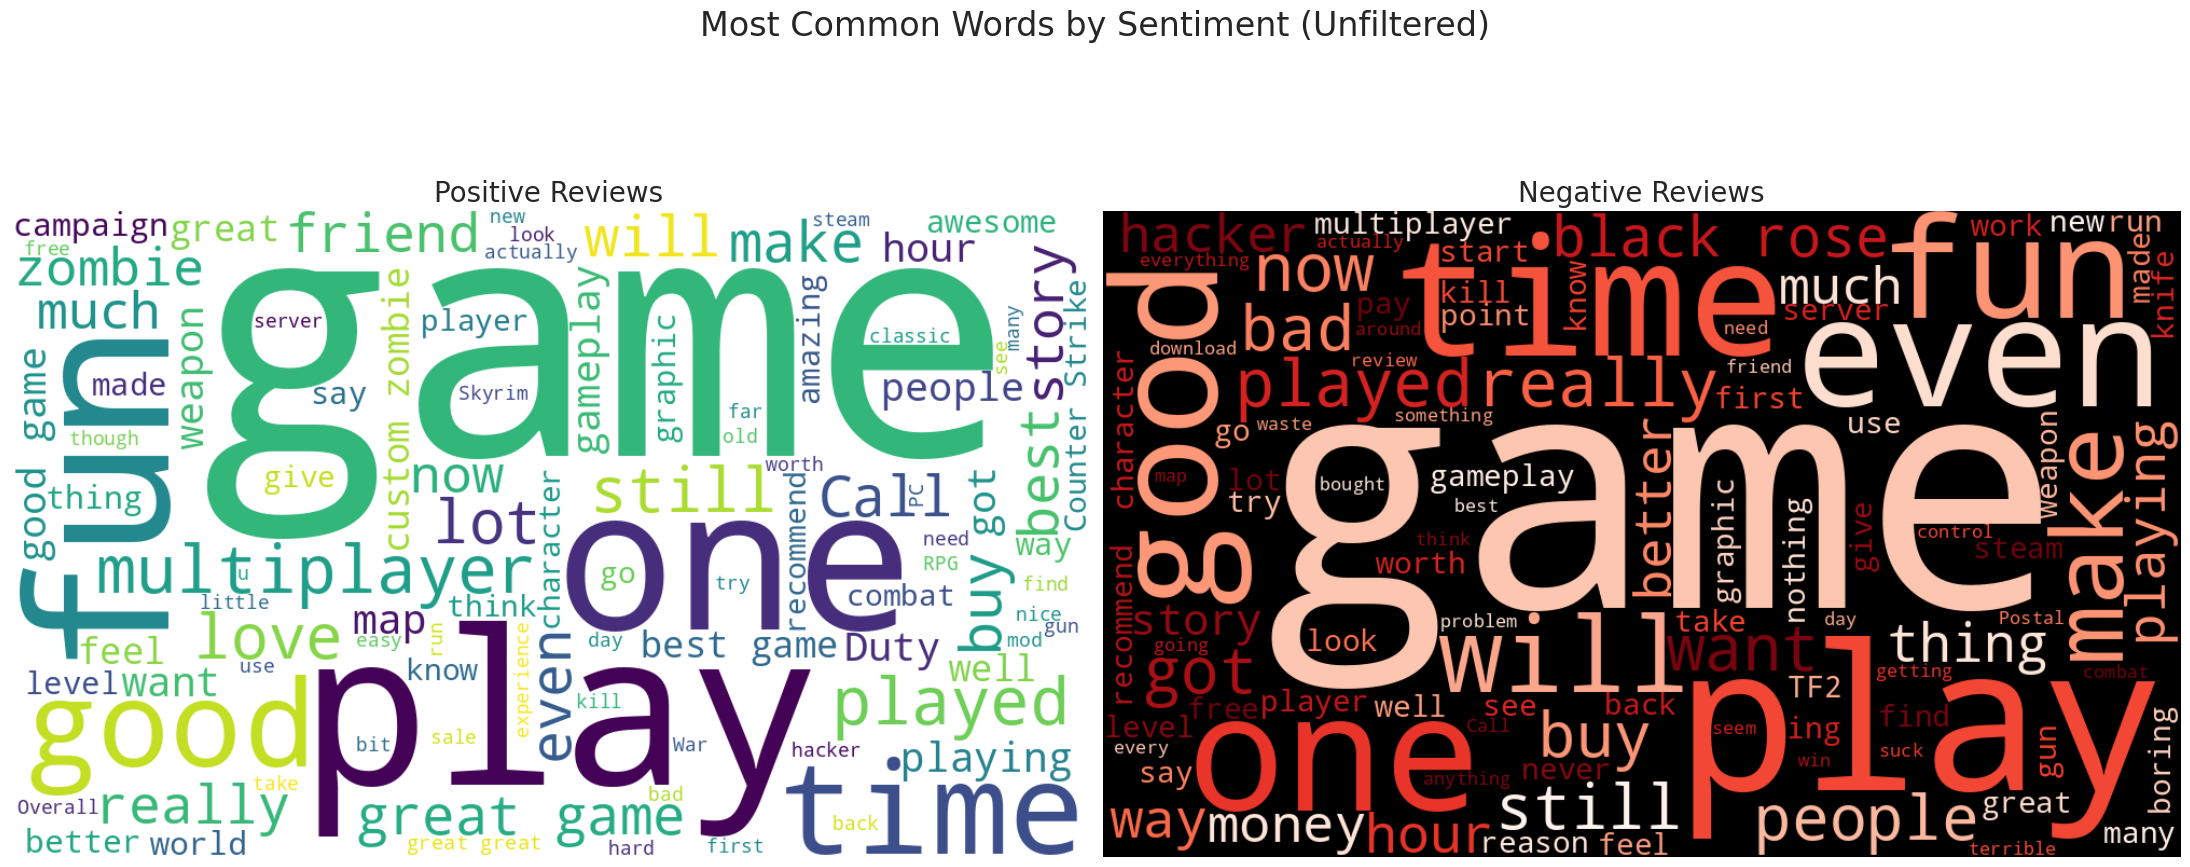

In [ ]:
# --- Exploratory Data Analysis (EDA) ---

# --- EDA: Unfiltered Word Cloud Analysis ---
print("\n--- Generating Unfiltered Word Clouds ---")

# --- Create a figure for side-by-side Word Clouds ---
fig, axes = plt.subplots(1, 2, figsize=(22, 10))
plt.suptitle("Most Common Words by Sentiment (Unfiltered)", fontsize=24, y=0.95)

# --- Word Cloud for POSITIVE Reviews ---
print("Generating Word Cloud for Positive Reviews...")
positive_text = ' '.join(review for review in df[df['sentiment'] == 'Positive']['review_text'])
wordcloud_positive = WordCloud(
    background_color='white',
    max_words=100,
    width=1000,
    height=600,
    colormap='viridis'
).generate(positive_text)

axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Reviews', fontsize=20)
axes[0].axis('off')

# --- Plot 2b: Word Cloud for NEGATIVE Reviews ---
print("Generating Word Cloud for Negative Reviews...")
negative_text = ' '.join(review for review in df[df['sentiment'] == 'Negative']['review_text'])
wordcloud_negative = WordCloud(
    # The 'stopwords' parameter is also removed here.
    background_color='black',
    max_words=100,
    width=1000,
    height=600,
    colormap='Reds'
).generate(negative_text)

axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Reviews', fontsize=20)
axes[1].axis('off')

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

**5. Data Preparation and Labeling**

Model to be used: distilroberta-base
Number of target labels: 10
Labels: ['Graphics/Art-Positive', 'Graphics/Art-Negative', 'Sound/Music-Positive', 'Sound/Music-Negative', 'Gameplay-Positive', 'Gameplay-Negative', 'Story-Positive', 'Story-Negative', 'Bugs-Negative', 'Performance-Negative']


/tmp/ipython-input-20-1283347286.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


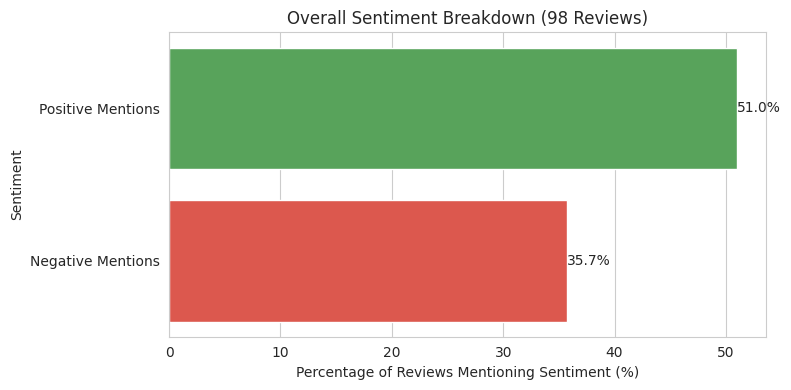

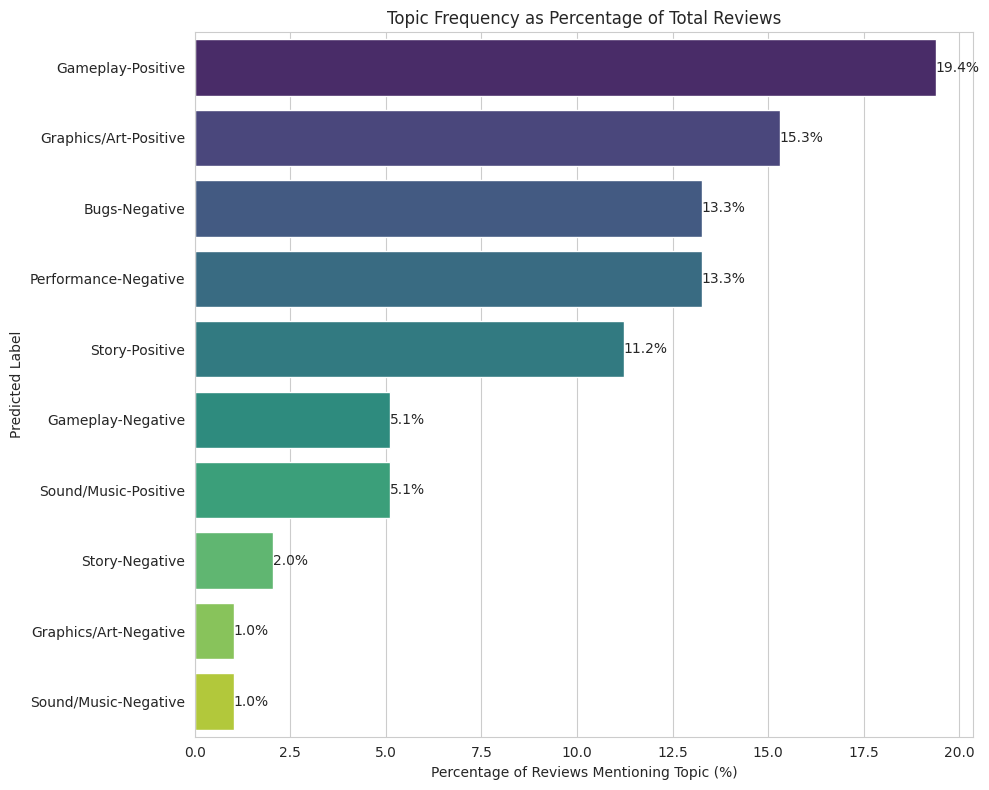

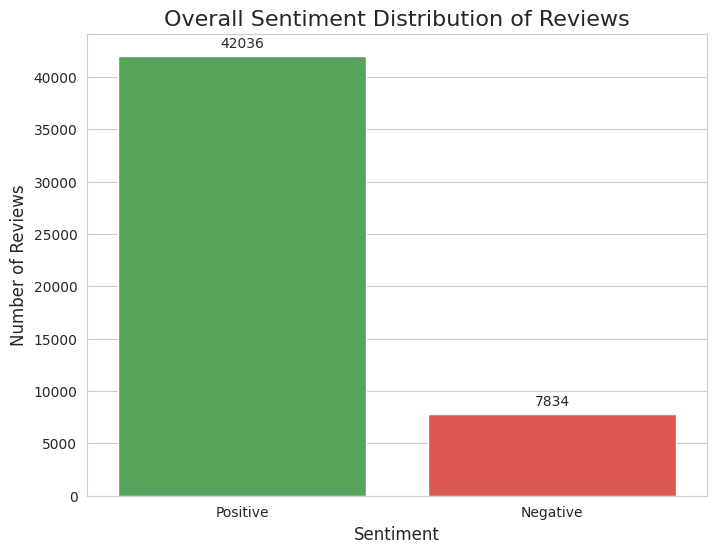

Creating custom labels based on keywords...
Custom labels created.
--- Visualizing the distribution of our final labels ---


/tmp/ipython-input-20-1283347286.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


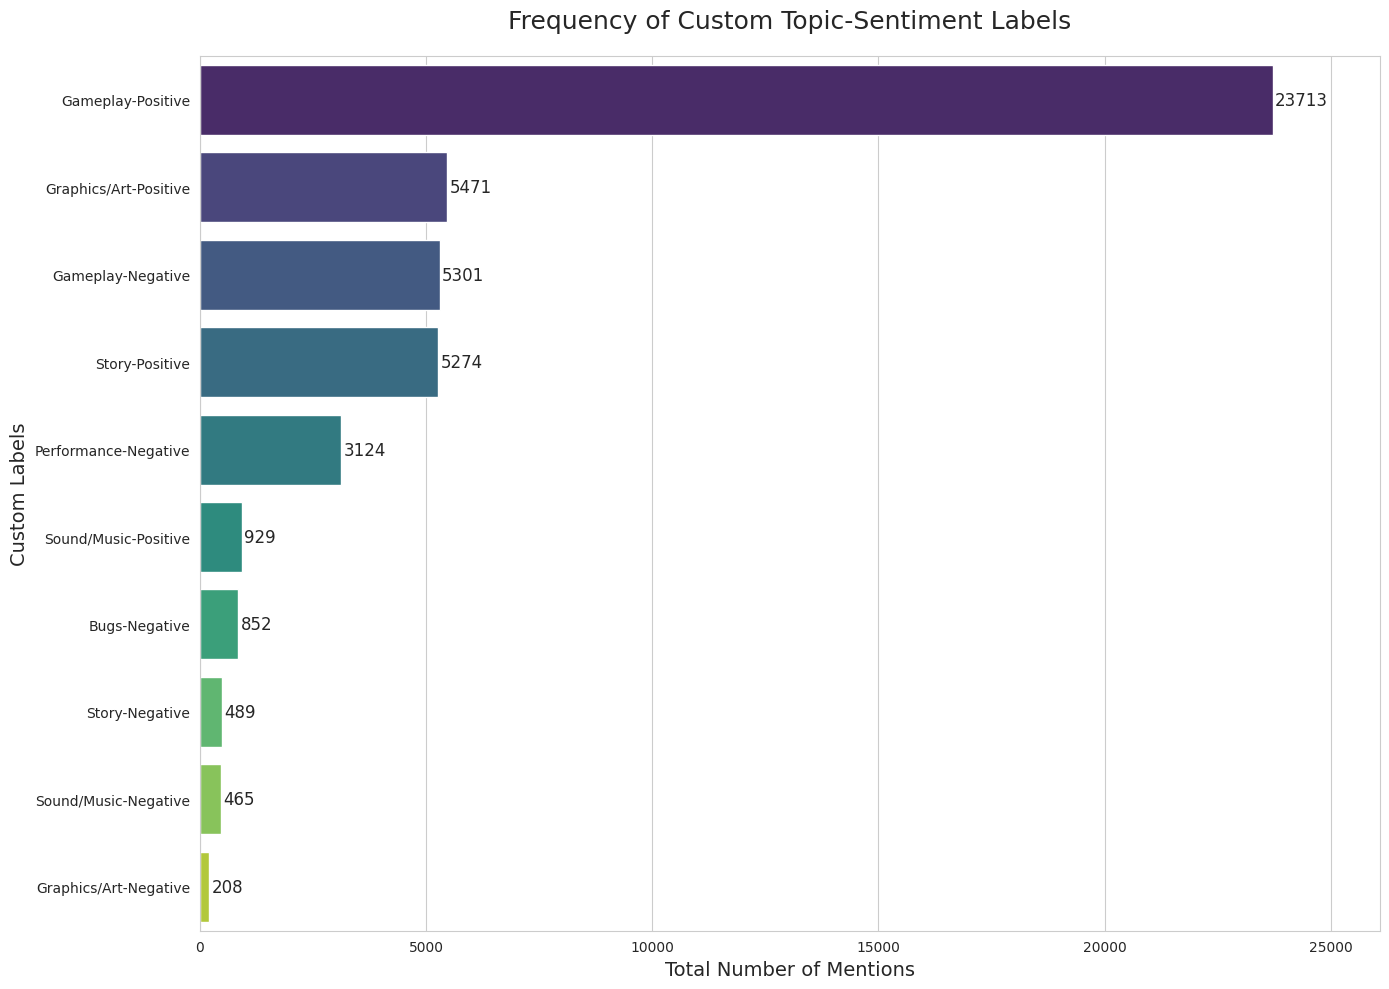

In [ ]:
# 10 Topic-Sentiment labels.
LABELS_CONFIG = {
    'Graphics/Art-Positive': ['graphic', 'graphics', 'beautiful', 'art', 'visuals', 'stunning', 'design', 'scenery', 'awesome'],
    'Graphics/Art-Negative': ['ugly', 'outdated', 'blurry', 'bad graphic'],
    'Sound/Music-Positive': ['soundtrack', 'music', 'audio', 'sfx', 'sound'],
    'Sound/Music-Negative': ['annoying', 'bad music', 'repetitive audio', 'muffled', 'distorted','no sound', 'cuts out', 'tinny', 'flat', 'poor voice', 'terrible sound'],
    'Gameplay-Positive': ['fun', 'gameplay', 'combat', 'controls', 'addictive', 'smooth','great', 'amazing', 'best', 'awesome', 'nice', 'friend'],
    'Gameplay-Negative': ['boring', 'bad', 'problem', 'terrible', 'waste', 'money', 'suck','hacker'],
    'Story-Positive': ['story', 'narrative', 'characters', 'writing', 'plot', 'well-written', 'campaign'],
    'Story-Negative': ['bad plot', 'no story', 'predictable', 'terrible'],
    'Bugs-Negative': ['bug', 'glitch', 'crash', 'freeze', 'broken', 'error'],
    'Performance-Negative': ['lag', 'fps', 'stutter', 'performance', 'server']
}
LABELS = list(LABELS_CONFIG.keys())
NUM_LABELS = len(LABELS)

print(f"Model to be used: {MODEL_NAME}")
print(f"Number of target labels: {NUM_LABELS}")
print(f"Labels: {LABELS}")


# This chart shows the balance between 'Positive' and 'Negative' reviews

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    x='sentiment',
    data=df,
    order=['Positive', 'Negative'], # Ensures a consistent order
    palette={'Positive': '#4CAF50', 'Negative': '#F44336'}
)

# --- Add Titles and Labels for Clarity ---
ax.set_title('Overall Sentiment Distribution of Reviews', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

# --- Add Count Labels on Top of the Bars ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',   # The number to display
                (p.get_x() + p.get_width() / 2., p.get_height()), # The (x,y) position
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

# --- Create Custom Topic-Sentiment Labels ---
print("Creating custom labels based on keywords...")
for label, keywords in LABELS_CONFIG.items():
    pattern = r'\b(?:' + '|'.join(keywords) + r')\b'
    df[label] = df['review_text'].str.contains(pattern, case=False, regex=True).astype(int)
print("Custom labels created.")

# ---  Final Label Distribution ---
print("--- Visualizing the distribution of our final labels ---")

# Calculate the counts for each label
topic_counts = df[LABELS].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 10)) # Increased size for better readability

# --- Create the bar plot with seaborn ---
ax = sns.barplot(
    x=topic_counts.values,
    y=topic_counts.index,
    palette='viridis'
)

# --- Improve the plot's titles and labels ---
ax.set_title('Frequency of Custom Topic-Sentiment Labels', fontsize=18, pad=20)
ax.set_xlabel('Total Number of Mentions', fontsize=14)
ax.set_ylabel('Custom Labels', fontsize=14)

# --- Add count labels to the end of each bar for clarity ---
for i, count in enumerate(topic_counts.values):
    ax.text(count + 50, i, str(count), ha='left', va='center', fontsize=12) # Added labels

# Adjust x-axis limit to give space for the text labels
ax.set_xlim(0, topic_counts.values.max() * 1.1)

# Make the plot look cleaner
plt.tight_layout()
plt.show()

**6. Targeted Data Augmentation**

In [ ]:
# --- Targeted Data Augmentation ---

# Our EDA bar chart highlighted a significant class imbalance.
# This set specifically targets our three weakest classes:
# 'Graphics/Art-Negative', 'Sound/Music-Negative', and 'Story-Negative'.

print("Creating and injecting an expanded 'Golden Set' of 30 manually labeled examples...")

golden_samples = [
    # === Category 1: Graphics/Art-Negative (10 Examples) ===
    {
        "review_text": "The character models are so ugly and outdated. It looks like a game from 10 years ago.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "The textures are incredibly blurry and low-res, even on the highest settings. Very uninspired art direction.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "Fun gameplay, but the graphics are just plain ugly. It's hard to look at for long periods.",
        "Labels": ['Gameplay-Positive', 'Graphics/Art-Negative']
    },
    {
        "review_text": "The world feels empty and the visual design is bland and forgettable.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "I was promised stunning visuals, but what I got was muddy textures and poor graphics.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "There's so much screen tearing, it's distracting. The art style can't save these technical graphical issues.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "The aesthetic is just a generic, uninspired mess. Nothing about the design stands out.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "This game is incredibly pixelated. It doesn't look like it was designed for modern monitors.",
        "Labels": ['Graphics/Art-Negative']
    },
    {
        "review_text": "Great story, but the outdated graphics really break the immersion.",
        "Labels": ['Story-Positive', 'Graphics/Art-Negative']
    },
    {
        "review_text": "The lighting is flat and the colors are washed out. The whole game looks dull.",
        "Labels": ['Graphics/Art-Negative']
    },

    # === Category 2: Sound/Music-Negative (10 Examples) ===
    {
        "review_text": "Had to mute the game. The soundtrack is incredibly repetitive and annoying.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "The voice acting is completely flat and emotionless. It's like the actors were just reading lines.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "Sound design is awful. All the weapon sound effects are weak and lack any impact.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "Great story, but the poor audio quality and muffled dialogue really took me out of the experience.",
        "Labels": ['Story-Positive', 'Sound/Music-Negative']
    },
    {
        "review_text": "The music loops every 30 seconds. It's maddeningly repetitive.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "Sounds are constantly crackling and distorting. Very poor sound quality.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "There is no sound for half the actions in the game. It feels unfinished.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "The audio mixing is a disaster. Character voices are drowned out by loud, generic music.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "The effects sound cheap and tinny. There's no weight to anything.",
        "Labels": ['Sound/Music-Negative']
    },
    {
        "review_text": "Fun gameplay, but the voice acting is so bad it's unintentionally hilarious.",
        "Labels": ['Gameplay-Positive', 'Sound/Music-Negative']
    },

    # === Category 3: Story-Negative (10 Examples) ===
    {
        "review_text": "The plot is full of plotholes and makes no sense. A very nonsensical and terrible story.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "The story is so predictable. I guessed the ending in the first hour. Very cliche writing.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "I have no idea what is going on. The game has almost no story or narrative to follow.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "The gameplay is fun, but the story is just a cringe-worthy, forgettable mess.",
        "Labels": ['Gameplay-Positive', 'Story-Negative']
    },
    {
        "review_text": "The characters are one-dimensional and the dialogue is just terrible writing from start to finish.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "An interesting premise that goes nowhere. The plot is completely underdeveloped.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "The main quest is just a series of boring fetch quests. There's no real narrative drive.",
        "Labels": ['Story-Negative', 'Gameplay-Negative']
    },
    {
        "review_text": "The ending felt so rushed and unsatisfying. It ruined the entire story for me.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "This story has been told a thousand times before, and better. Very unoriginal and forgettable.",
        "Labels": ['Story-Negative']
    },
    {
        "review_text": "I couldn't connect with any of the characters. The writing for them is just so shallow.",
        "Labels": ['Story-Negative']
    }
]

# Convert this list of dictionaries to a DataFrame
golden_df = pd.DataFrame(golden_samples)

# --- One-Hot Encode the Labels for the Golden Set ---
for label in LABELS:
    golden_df[label] = golden_df['Labels'].apply(lambda x: 1 if label in x else 0)
golden_df = golden_df.drop(columns=['Labels'])

# --- Add the Golden Set to the Main DataFrame ---
df = pd.concat([df, golden_df], ignore_index=True)

print(f"\nExpanded Golden Set injected. New total number of reviews: {len(df)}")

Creating and injecting an expanded 'Golden Set' of 30 manually labeled examples...

Expanded Golden Set injected. New total number of reviews: 49900


**7. Data Formatting & Tokenization**

In [ ]:
# --- 1. Format DataFrame ---
df['labels'] = df[LABELS].values.tolist()
df['labels'] = df['labels'].apply(lambda x: [float(i) for i in x])
df_model = df[['review_text', 'labels']].rename(columns={'review_text': 'text'})

# --- 2. Convert to Hugging Face Dataset & Tokenize ---
dataset = Dataset.from_pandas(df_model)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# --- 3. Split into Training and Evaluation Sets ---
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]
print(f"\nData ready for training: {len(train_dataset)} training samples, {len(eval_dataset)} evaluation samples.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/49900 [00:00<?, ? examples/s]


Data ready for training: 39920 training samples, 9980 evaluation samples.


**8. Class Weights**

In [ ]:
# --- Calculate Class Weights to Handle Imbalance ---
print("Calculating class weights from the training data...")

labels_array = np.array(train_dataset['labels'])
label_counts = labels_array.sum(axis=0)
class_weights = (len(train_dataset) - label_counts) / (label_counts + 1e-6)

# Convert weights to a PyTorch tensor to be used by the loss function
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print("\nCalculated weights for each class (higher weight for rarer classes):")
for label, weight in zip(LABELS, class_weights_tensor):
    print(f"{label:<25}: {weight:.2f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

# --- Create a Custom Trainer to Use Class Weights ---

# Penalize mistakes on rare classes more heavily.

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

print("CustomTrainer with weighted loss has been defined.")

Calculating class weights from the training data...

Calculated weights for each class (higher weight for rarer classes):
Graphics/Art-Positive    : 8.15
Graphics/Art-Negative    : 227.11
Sound/Music-Positive     : 54.52
Sound/Music-Negative     : 122.21
Gameplay-Positive        : 1.11
Gameplay-Negative        : 8.49
Story-Positive           : 8.62
Story-Negative           : 102.69
Bugs-Negative            : 57.71
Performance-Negative     : 14.96
CustomTrainer with weighted loss has been defined.


**9. Model Training**

In [ ]:
# --- 1. Load Model with Multi-Label Configuration ---
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# --- 2. Set Up Training Arguments ---
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    report_to="none",
)

# --- 3. Create the Trainer ---
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# --- 4. Start the Training Process ---
print("Starting model fine-tuning (using CUSTOM trainer with weighted loss)...")
trainer.train()
print("Training complete.")

# --- 5. Save the Final Model ---
final_model_path = "./final_steam_review_model"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"Final model saved to {final_model_path}")

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-17-515287118.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Starting model fine-tuning (using CUSTOM trainer with weighted loss)...


Step,Training Loss
500,0.889700
1000,0.328100
1500,0.362900
2000,0.340900
2500,0.350600
3000,0.220200
3500,0.259300
4000,0.290600
4500,0.256600
5000,0.271600


Training complete.
Final model saved to ./final_steam_review_model


**10. Model Evaluation**

--- Starting Complete Evaluation Process ---
Loading model from: /content/drive/MyDrive/final_steam_review_model

Running prediction on the test set...



--- Overall Model Performance (Summary) ---


Metric,Value
Accuracy,0.972100
F1 Score (Micro),0.972700
ROC AUC (Micro),0.999100



--- Detailed Classification Report (Per Label) ---
                       precision    recall  f1-score   support

Graphics/Art-Positive     0.9557    0.9818    0.9686      1098
Graphics/Art-Negative     0.6818    0.7692    0.7229        39
 Sound/Music-Positive     0.7897    0.9109    0.8460       202
 Sound/Music-Negative     0.6986    0.7500    0.7234        68
    Gameplay-Positive     0.9945    0.9960    0.9953      4751
    Gameplay-Negative     0.9370    0.9826    0.9592      1090
       Story-Positive     0.9682    0.9830    0.9755      1115
       Story-Negative     0.7937    0.9091    0.8475       110
        Bugs-Negative     0.8626    0.9128    0.8870       172
 Performance-Negative     0.9558    0.9727    0.9641       622

            micro avg     0.9632    0.9824    0.9727      9267
            macro avg     0.8638    0.9168    0.8889      9267
         weighted avg     0.9646    0.9824    0.9732      9267
          samples avg     0.5609    0.5638    0.5609      9267



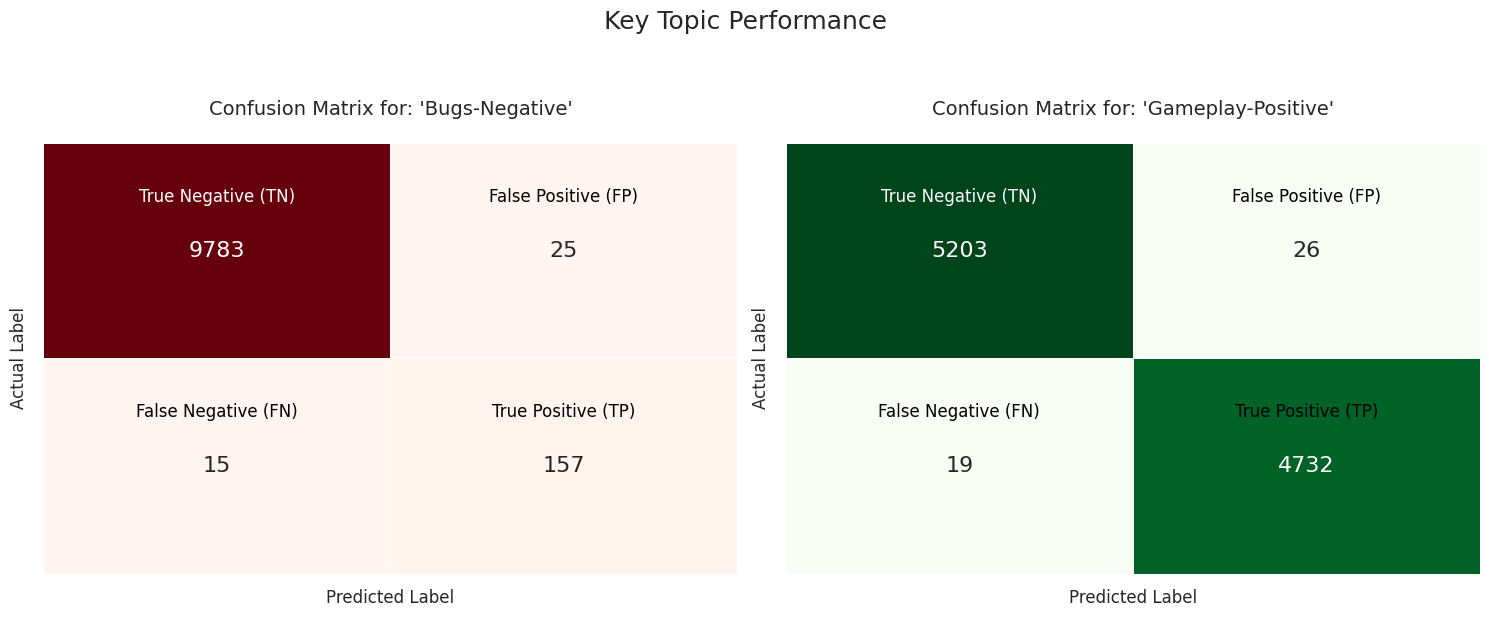

In [ ]:
print("--- Starting Complete Evaluation Process ---")

# --- 1. Load the fine-tuned model and tokenizer ---

#for saved model
final_model_path = "/content/drive/MyDrive/final_steam_review_model"

#for current trained model
#final_model_path = "./final_steam_review_model"

print(f"Loading model from: {final_model_path}")
loaded_model = AutoModelForSequenceClassification.from_pretrained(final_model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(final_model_path)

# --- 2. Create a Trainer instance ---
eval_trainer = Trainer(
    model=loaded_model,
    args=TrainingArguments(output_dir="./eval_results", report_to="none"),
)

# --- 3. Get Predictions ONCE (More Efficient) ---
print("\nRunning prediction on the test set...")
predictions_output = eval_trainer.predict(eval_dataset)

# Extract predictions and true labels
y_preds_logits = predictions_output.predictions[0] if isinstance(predictions_output.predictions, tuple) else predictions_output.predictions
y_true = predictions_output.label_ids

# Convert logits to probabilities and then to predicted labels (0s and 1s)
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(y_preds_logits))
y_pred = (probs > 0.5).int().numpy()

# --- 4. Calculate and Display Summary Metrics ---
print("\n--- Overall Model Performance (Summary) ---")
summary_metrics = {
    "Accuracy": accuracy_score(y_true=y_true, y_pred=y_pred),
    "F1 Score (Micro)": f1_score(y_true=y_true, y_pred=y_pred, average='micro'),
    "ROC AUC (Micro)": roc_auc_score(y_true=y_true, y_score=probs, average='micro')
}
summary_df = pd.DataFrame(list(summary_metrics.items()), columns=['Metric', 'Value'])
summary_df['Value'] = summary_df['Value'].round(4)
display(summary_df.style.hide(axis="index"))


# --- 5. Display Per-Label Classification Report ---
print("\n--- Detailed Classification Report (Per Label) ---")
# Get the label names dynamically from the model's configuration
label_names = LABELS
report = classification_report(y_true, y_pred, target_names=label_names, digits=4, zero_division=0)
print(report)


# --- 6. Detailed Confusion Matrices for Key Labels ---

print("\n--- Detailed Confusion Matrices for Key Labels ---")

key_labels_to_plot = {
    "Bugs-Negative": "Reds",
    "Gameplay-Positive": "Greens"
}

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Key Topic Performance', fontsize=18, y=1.02)

# We use zip to iterate through our chosen labels and the subplot axes at the same time
for i, (label_name, cmap) in enumerate(key_labels_to_plot.items()):
    ax = axes[i]

    try:
        label_index = LABELS.index(label_name)
    except ValueError:
        ax.text(0.5, 0.5, f"Label '{label_name}'\nnot found.",
                ha='center', va='center', fontsize=12)
        ax.set_title(f"Error: Label Not Found", color='red')
        continue

    # Calculate the confusion matrix for this specific label
    cm = confusion_matrix(
        y_true=y_true[:, label_index],
        y_pred=y_pred[:, label_index]
    )

    # Plot the heatmap on the specific subplot axis 'ax'
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False,
                annot_kws={"size": 16}, linewidths=.5)

    # Set the title for this individual subplot
    ax.set_title(f"Confusion Matrix for: '{label_name}'", fontsize=14, pad=20)

    # Set main axis labels
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)

    # The coordinates are (x, y) where (0.5, 0.5) is the center of the top-left cell.
    ax.text(0.5, 0.25, 'True Negative (TN)', ha='center', va='center', color='white', fontsize=12)
    ax.text(1.5, 0.25, 'False Positive (FP)', ha='center', va='center', color='black', fontsize=12)
    ax.text(0.5, 1.25, 'False Negative (FN)', ha='center', va='center', color='black', fontsize=12)
    ax.text(1.5, 1.25, 'True Positive (TP)', ha='center', va='center', color='black', fontsize=12)

    # Remove the default numeric tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Adjust the layout to prevent titles from overlapping and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**11. Model Prediction**

In [ ]:
# --- Prediction Pipeline for Demo ---

# For current trained model
# MODEL_PATH = "./final_steam_review_model"

# For saved model
MODEL_PATH = "/content/drive/MyDrive/final_steam_review_model"

# Load the tokenizer from the saved directory
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load the fine-tuned model from the saved directory
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Ensure model, tokenizer, and LABELS list are accessible from previous cells
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set model to evaluation mode

# Function for single text prediction
def predict_for_gradio(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.sigmoid(logits.squeeze())
    confidences = {LABELS[i]: float(prob) for i, prob in enumerate(probs)}
    return confidences

# --- Function to analyze CSV and generate TWO plots with percentages ---
def analyze_csv_to_dashboard(uploaded_file):

    """
    Analyzes an uploaded CSV file containing game reviews. This function reads the file,
    runs predictions for each review using the pre-loaded model, and returns a single
    figure formatted as a multi-panel dashboard. It is robustly designed to handle
    cases with no detected labels.
    """
    # Import the necessary layout manager from matplotlib
    from matplotlib.gridspec import GridSpec

    # --- 1. Initial File Check ---
    if uploaded_file is None:
        # Create and return a blank plot if no file is uploaded
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.text(0.5, 0.5, "Please upload a CSV file to begin.",
                ha='center', va='center', fontsize=16, color='gray')
        ax.axis('off')
        return fig

    try:
        # --- 2. Load and Validate Data ---
        df = pd.read_csv(uploaded_file.name)
        if 'review_text' not in df.columns:
            raise ValueError("Invalid CSV: Must contain a 'review_text' column.")

        # --- 3. Run Model Predictions ---
        reviews_to_analyze = df['review_text'].dropna()
        total_reviews = len(reviews_to_analyze)

        all_predictions = []
        for text in reviews_to_analyze:
            inputs = tokenizer(str(text), padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
            with torch.no_grad():
                logits = model(**inputs).logits
            probs = torch.sigmoid(logits.squeeze())
            predictions = (probs >= 0.5).int().cpu().numpy()
            predicted_labels = [LABELS[i] for i, pred in enumerate(predictions) if pred == 1]
            all_predictions.extend(predicted_labels)

        # --- 4. Calculate All Metrics Before Plotting ---
        positive_count = sum(1 for label in all_predictions if 'Positive' in label)
        negative_count = sum(1 for label in all_predictions if 'Negative' in label)
        bug_count = sum(1 for label in all_predictions if 'Bugs' in label)
        label_counts = Counter(all_predictions)

        # --- 5. Create the Dashboard Figure and Layout ---
        fig = plt.figure(figsize=(18, 14))
        gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 2.5])
        fig.suptitle(f'Game Review Analysis Dashboard ({total_reviews} Reviews)', fontsize=24, y=0.97)

        # --- 6. Build All Dashboard Components ---

        # Component A: Key Metrics Panel (Top-Left)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.set_title("Key Metrics", fontsize=18, pad=20)
        ax1.axis('off')
        ax1.text(0.05, 0.8, "Total Reviews Analyzed:", fontsize=16, weight='bold', color='blue')
        ax1.text(0.8, 0.8, f"{total_reviews}", fontsize=16, ha='right')
        ax1.text(0.05, 0.55, "Positive Mentions:", fontsize=16, weight='bold', color='green')
        ax1.text(0.8, 0.55, f"{positive_count}", fontsize=16, ha='right')
        ax1.text(0.05, 0.3, "Negative Mentions:", fontsize=16, weight='bold', color='red')
        ax1.text(0.8, 0.3, f"{negative_count}", fontsize=16, ha='right')
        ax1.text(0.05, 0.05, "Critical Bug Reports:", fontsize=16, weight='bold', color='orange')
        ax1.text(0.8, 0.05, f"{bug_count}", fontsize=16, ha='right')

        # Component B: Sentiment Pie Chart (Top-Right)
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.set_title("Sentiment Mention Mix", fontsize=18, pad=20)
        if positive_count > 0 or negative_count > 0:
            ax2.pie([positive_count, negative_count],
                    labels=['Positive', 'Negative'],
                    autopct='%1.1f%%',
                    startangle=90,
                    colors=['#4CAF50', '#F44336'],
                    textprops={'fontsize': 14})
        else:
            ax2.text(0.5, 0.5, "No sentiment detected.", ha='center', va='center', color='gray')
            ax2.axis('off')

        # Component C: Detailed Topic Breakdown (Bottom)
        ax3 = fig.add_subplot(gs[1, :])
        ax3.set_title('Top 10 Most Frequent Topics & Sentiments', fontsize=18, pad=25)

        if not label_counts:
            ax3.text(0.5, 0.5, "No specific topics were detected.", ha='center', va='center', color='gray')
            ax3.axis('off')
        else:
            plot_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count']).sort_values('Count', ascending=False).head(10)
            sns.barplot(x='Count', y='Label', data=plot_df, ax=ax3, palette='viridis')
            ax3.set_xlabel('Total Number of Mentions', fontsize=14)
            ax3.set_ylabel('')
            ax3.tick_params(axis='both', which='major', labelsize=12)

            for p in ax3.patches:
                width = p.get_width()
                ax3.text(width + 0.3, p.get_y() + p.get_height() / 2, f'{int(width)}', ha='left', va='center', fontsize=12)

        # --- 7. Final Layout Adjustment and Return ---
        plt.tight_layout(rect=[0, 0, 1, 0.94])

        return fig

    except Exception as e:
        # Create a plot with an error message if anything fails
        print(f"An error occurred in analyze_csv_to_dashboard: {str(e)}")
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.text(0.5, 0.5, f"An error occurred:\n{str(e)}",
                ha='center', va='center', fontsize=14, color='red', wrap=True)
        ax.axis('off')
        return fig

# --- 4. Create and Launch the Gradio Demo ---
print("--- Launching Advanced Game Review Analyzer with Gradio ---")

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# Advanced Game Review Analyzer Dashboard")

    with gr.Tabs():
        # --- Tab 1: Single Review Analysis ---
        with gr.TabItem("Single Review Analyzer"):
            gr.Interface(
                fn=predict_for_gradio,
                inputs=gr.Textbox(lines=5, label="Game Review Text", placeholder="Enter your game review here..."),
                outputs=gr.Label(num_top_classes=4, label="Predicted Topics & Sentiment"),
                title="Single Review Analysis",
                description="Enter one review to see how the model categorizes it instantly.",
                examples=[
                    ["I love the new story missions and the fun gameplay!"],
                    ["The performance is terrible with constant lag spikes and the story is so bad!"],
                    ["So many bug, constantly crashes! It crashed twice in the first hour and my character got stuck in a wall."],
                    ["Absolutely beautiful art style and the scenery is stunning. A real visual treat."],
                    ["Bad plot, no story at all, predictable, terrible overall 0/10"],
                    ["So lag how to play ah?"]
                ]
            )

        # --- Tab 2: Batch CSV Analysis ---
        with gr.TabItem("Batch CSV Analysis Dashboard"):
            gr.Markdown("Upload a CSV file with a 'review_text' column to get an overview of all reviews.")
            with gr.Row():
                file_input = gr.File(label="Upload Review CSV")
                analyze_button = gr.Button("Generate Dashboard")

            # We now only need ONE plot output for the whole dashboard
            dashboard_output = gr.Plot(label="Analysis Dashboard")

            analyze_button.click(fn=analyze_csv_to_dashboard, inputs=file_input, outputs=dashboard_output)

demo.launch(debug=True)

--- Launching Advanced Game Review Analyzer with Gradio ---
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f6665f306bc44f8c32.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-49-3326462270.py:126: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-49-3326462270.py:126: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




**12. Output Example :**

1. Single review

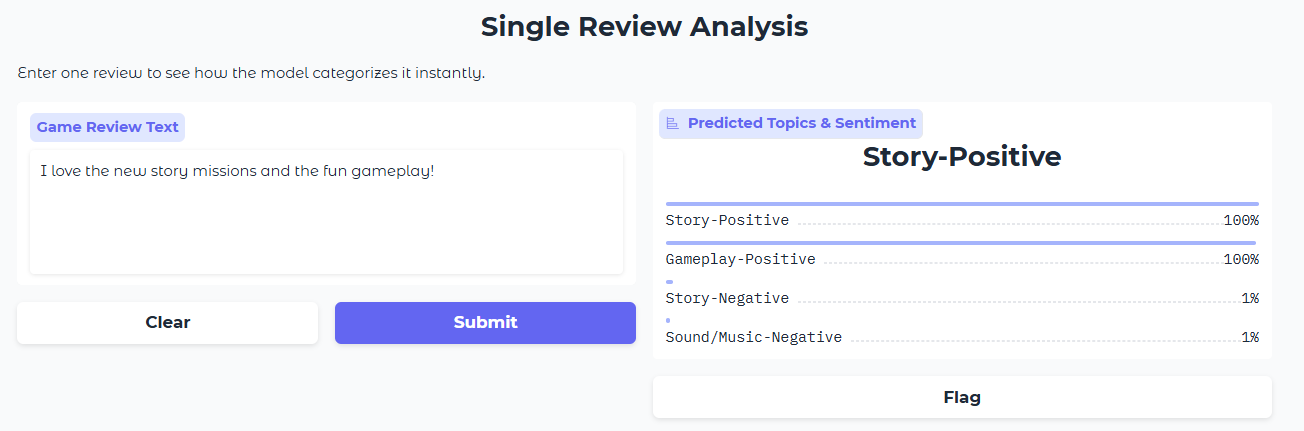

2. csv file upload reviews

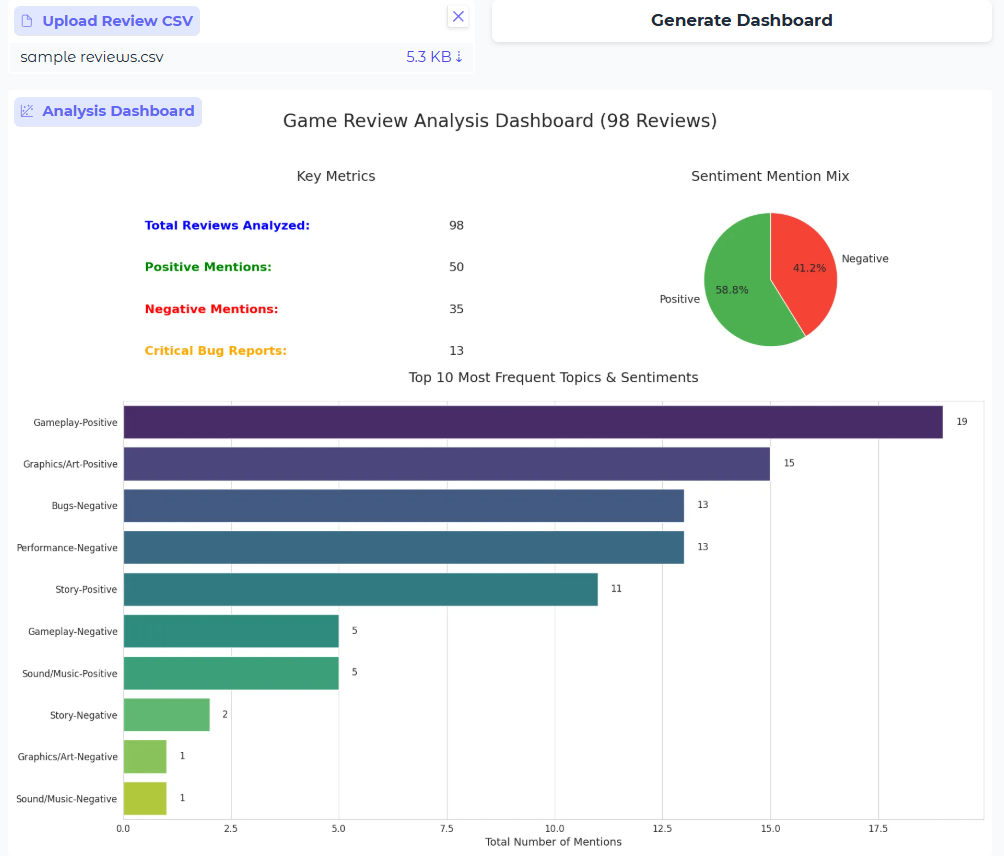

**For Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
